# Train a Deep Koopman model using the Keras framework

Original code by dykua at https://github.com/dykuang/Deep----Koopman

Modifications by Brendan 26/8/21

# Experimental Parameters

In [1]:
#load_data = True
load_data = False

In [2]:
# model_type = 'FCN'
model_type = 'DKN'

In [3]:
# Choose whether to use time-delay embeddings, or not

NUM_HISTORICAL_TRAINING_INPUT_STEPS = 50 # State is formed of 50 previous timesteps (delay)
# NUM_HISTORICAL_TRAINING_INPUT_STEPS = 1 # State only consists of the current timestep (no delay)

In [4]:
# system = 'Rigid.no.control.delay'
#system = 'Rigid.control.delay'
system = 'Soft.control.delay'

In [5]:
# old_arch = True
old_arch = False

In [6]:
# If DKN, select these
num_complex_eig_funs = 1
num_real_eig_funs = 0

# Learning code

In [7]:
top_level = '../src/20220309_easy'

In [8]:
if model_type=='FCN':
    model_directory = '{}/models/{}/{}.timesteps/{}'.format(top_level,model_type,NUM_HISTORICAL_TRAINING_INPUT_STEPS,system)
elif model_type =='DKN':
    model_directory = '{}/models/{}/{}.timesteps/{}.{}c.{}r.eigfn'.format(top_level,model_type,NUM_HISTORICAL_TRAINING_INPUT_STEPS,system,num_complex_eig_funs,num_real_eig_funs)
data_directory = top_level

In [9]:
%killbgscripts

All background processes were killed.


In [10]:
#from numba import cuda
#cuda.select_device(0)
#cuda.close()
from keras import backend as K
K.clear_session()

2022-03-31 16:49:24.105148: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Using TensorFlow backend.


In [11]:
%matplotlib notebook
#%load_ext tensorboard

In [12]:
# Needed for running custom loss
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam

if not load_data:
    disable_eager_execution()

import matplotlib.pyplot as plt
import h5py
import numpy as np
import keras

In [13]:
# Fix the seed, for evaluation
# Remove this to explore generalisability
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
#gpus = tf.config.experimental.list_physical_devices('GPU')

In [15]:
from datetime import datetime
import pickle
import itertools
import os

In [16]:
import sys
sys.path.append('../fromServer_Keras-HDF5-ImageDataGenerator/')
from h5imagegenerator.generator import HDF5ImageGenerator
from albumentations import Compose,Crop,ToFloat,Normalize

In [17]:
import matplotlib
from IPython.display import HTML
from matplotlib import animation, image
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [18]:
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [19]:
# setting parameters
BATCH_SIZE = 128 # BEST for state, 2 seems to never converge
# EPOCHS = 3
EPOCHS = 250
DATA_TIMESTEPS = 50

# Load the data

In [20]:
if system == 'Rigid.no.control.delay':
    dt = 0.02
   
    if load_data:
        full_model = keras.models.load_model('{}/full_model'.format(model_directory),compile=False)
        encoder = keras.models.load_model('{}/encoder'.format(model_directory),compile=False)
        _decoder = keras.models.load_model('{}/decoder'.format(model_directory),compile=False)
        Knet = keras.models.load_model('{}/Knet'.format(model_directory),compile=False)
        custom_Knet= keras.models.load_model('{}/custom_Knet'.format(model_directory),compile=False)
 
    xmax_state = 2 
    num_control = 0

    augmentor = Compose([
        Crop(x_min=0,  x_max=xmax_state,y_min=DATA_TIMESTEPS-NUM_HISTORICAL_TRAINING_INPUT_STEPS, y_max=DATA_TIMESTEPS),
    ])
    augmenter_labels = Compose([
        Crop(x_min=0,  x_max=xmax_state,y_min=DATA_TIMESTEPS-NUM_HISTORICAL_TRAINING_INPUT_STEPS, y_max=DATA_TIMESTEPS),
    ])

elif system == 'Rigid.control.delay':
    dt = 0.02
   
    if load_data:
        full_model = keras.models.load_model('{}/full_model'.format(model_directory),compile=False)
        encoder = keras.models.load_model('{}/encoder'.format(model_directory),compile=False)
        _decoder = keras.models.load_model('{}/decoder'.format(model_directory),compile=False)
        Knet = keras.models.load_model('{}/Knet'.format(model_directory),compile=False)
        custom_Knet= keras.models.load_model('{}/custom_Knet'.format(model_directory),compile=False)
    
    
    xmax_state = 3 
    num_control = 1

    augmentor = Compose([
        Crop(x_min=0,  x_max=xmax_state,y_min=DATA_TIMESTEPS-NUM_HISTORICAL_TRAINING_INPUT_STEPS, y_max=DATA_TIMESTEPS),
    ])
    augmenter_labels = Compose([
        Crop(x_min=0,  x_max=xmax_state,y_min=DATA_TIMESTEPS-NUM_HISTORICAL_TRAINING_INPUT_STEPS, y_max=DATA_TIMESTEPS),
    ])

elif system =='Soft.control.delay':
    dt = 0.05
    
    if load_data:
        full_model = keras.models.load_model('{}/full_model'.format(model_directory),compile=False)
        encoder = keras.models.load_model('{}/encoder'.format(model_directory),compile=False)
        _decoder = keras.models.load_model('{}/decoder'.format(model_directory),compile=False)
        Knet = keras.models.load_model('{}/Knet'.format(model_directory),compile=False)
        custom_Knet= keras.models.load_model('{}/custom_Knet'.format(model_directory),compile=False)
    
    xmax_state = 4 
    num_control = 1

    augmentor = Compose([
        Crop(x_min=0,  x_max=xmax_state,y_min=DATA_TIMESTEPS-NUM_HISTORICAL_TRAINING_INPUT_STEPS, y_max=DATA_TIMESTEPS),

    ])
    augmenter_labels = Compose([
        Crop(x_min=0,  x_max=xmax_state,y_min=DATA_TIMESTEPS-NUM_HISTORICAL_TRAINING_INPUT_STEPS, y_max=DATA_TIMESTEPS),

    ])
    
NUM_HISTORICAL_TRAINING_LATENT_STEPS = NUM_HISTORICAL_TRAINING_INPUT_STEPS
NUM_HISTORICAL_TRAINING_OUTPUT_STEPS = NUM_HISTORICAL_TRAINING_INPUT_STEPS 
NUM_HISTORICAL_LOSS_PREDICTION_STEPS = NUM_HISTORICAL_TRAINING_INPUT_STEPS

In [21]:
X_key = 'state_t'
y_key = 'state_tp1'
classes_key = 'state_tp1'

In [22]:
# Define generators on the HDF5 files
# By using generators, we don't need to load all samples into memory at once. Its a bit slower, but it means we can used many more samples
# Define a generator where input is state at t, and output is state at t+1
train_generator = HDF5ImageGenerator(
        src = data_directory+'/train.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, 
        labels_encoding=False,
        batch_size=BATCH_SIZE,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, 
        shuffle=True,
)

valid_generator = HDF5ImageGenerator(
        src=data_directory+'/valid.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False,
        labels_encoding=False,
        batch_size=BATCH_SIZE,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, 
        shuffle=True,
)

test_generator = HDF5ImageGenerator(
        src=data_directory+'/test.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False,
        labels_encoding=False,
        batch_size=BATCH_SIZE,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels,
        shuffle=True,
)

EVALUATION_INTERVAL = len(train_generator._indices) // BATCH_SIZE
VALIDATION_STEPS = len(valid_generator._indices) // BATCH_SIZE

In [23]:
# Check to see if the loaded data is in the (approximate) range [0,1] (easier for training)
print(train_generator[0][0][:,:,0].min(),train_generator[0][0][:,:,0].max())
print(train_generator[0][1][:,:,0].min(),train_generator[0][1][:,:,0].max())
print(train_generator[0][0][:,:,1].min(),train_generator[0][0][:,:,1].max())
print(train_generator[0][1][:,:,1].min(),train_generator[0][1][:,:,1].max())
#print(train_generator[0][0][:,:,2].min(),train_generator[0][0][:,:,2].max())
#print(train_generator[0][1][:,:,2].min(),train_generator[0][1][:,:,2].max())

# View the shape of a batch (this should be (BATCHSIZE,NUM_HISTORICAL_TRAINING_INPUT_STEPS,xmax_state))
print(train_generator[0][0].shape)
print(train_generator[0][1].shape)

-1.3830392784578163 1.6098565374998721
-1.3830392784578163 1.6098565374998721
-1.6540923925358904 2.0583521216393477
-1.6540923925358904 2.0583521216393477
(128, 50, 4)
(128, 50, 4)


<IPython.core.display.Javascript object>


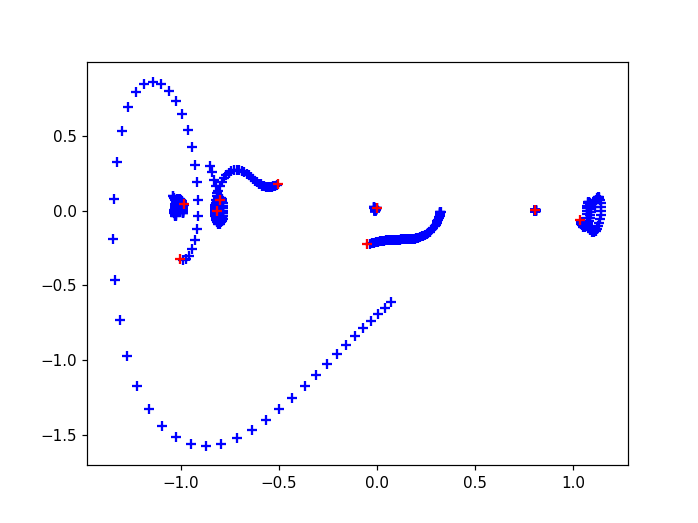

In [24]:
fig = plt.figure()
for i in range(10):
    plt.scatter(train_generator[0][0][i,:,0],train_generator[0][0][i,:,1],color='b',marker='+')
    plt.scatter(train_generator[0][1][i,-1,0],train_generator[0][1][i,-1,1],color='r',marker='+')

In [25]:
# Best settings I've found so far for the 2D state data
par = {
       'input steps':NUM_HISTORICAL_TRAINING_INPUT_STEPS,
       'latent steps':NUM_HISTORICAL_TRAINING_LATENT_STEPS,
       'output steps':NUM_HISTORICAL_TRAINING_OUTPUT_STEPS,
       'pred steps': NUM_HISTORICAL_LOSS_PREDICTION_STEPS,
       'batch size': BATCH_SIZE,
       'en dim list': [80,80],
       'de dim list': [80,80,],
       'K reg': 10e-14,
       'epochs': EPOCHS,
       'data name': 'Pendulum.mat', 
       'num complex': num_complex_eig_funs,  
        'num real': num_real_eig_funs,
       'hidden_widths_omega': [170], # the width of the auxiliary network 
       'lr': 0.001,
       'alpha_1' : 0.001, 
        'alpha_2' : 10e-9, 
       'alpha_3' : 10e-14,
       'save name': 'pendulum_state',
       'dt' : dt
       }
par['num_samples'], par['time steps'], par['input feature dim'] = train_generator[0][0].shape
par['num_samples'], par['time steps'], par['output feature dim'] = train_generator[0][1].shape
input_shape = (par['input steps'], par['input feature dim'])
output_shape = (par['input steps'], par['output feature dim'])

# Latent dimension
par['latent dim'] = 2*par['num complex'] + par['num real']
latent_shape = (par['latent steps'],)+ (par['latent dim'],)

# Define models

In [26]:
if not load_data:

    from tensorflow.keras.layers import Input, Reshape
    from Architecture import _transformer,_pred_K, linear_update

    '''
    Losses
    '''
    from keras.losses import mean_squared_error, mean_absolute_error

    def S_error(args):
        Y0, Y1 = args
        return tf.reduce_mean(tf.math.squared_difference(Y0,Y1))
    
    def I_error(args):
        Y0, Y1 = args
        return tf.math.reduce_max(tf.abs(Y0-Y1))

    def State_loss(yTrue, yPred):
        return tf.reduce_mean(tf.math.squared_difference(encoder(yTrue),KGx))

    # The plain old reconstruction loss
    def Rec_loss(yTrue, yPred):
        return tf.reduce_mean(tf.math.squared_difference(
            x_in[:,:,:xmax_state-num_control],
            decoded_x[:,:,:xmax_state-num_control]))

    # The mean reconstruction loss over m steps into the future
    def Rec_plus1_loss(yTrue, yPred):
        return tf.reduce_mean(tf.math.squared_difference(
            yTrue[:,:,:xmax_state-num_control], # only interested in the state, not the control
            yPred[:,:,:xmax_state-num_control]) # only interested in the state, not the control
                             )
    
    def customLoss():
        # yTrue is the actual value X_t+1
        # yPred is the predicted reconstruction at X_t+1 (as this is the output of full_model, aka decoded_xp)
        # However, yPred is not actally needed when computing the (custom) loss, instead:
        # 1) L_recon is the MSE between X_t and the prediction of X_t
        # 2) L_pred is the MSE between X_t+m and the prediction of X_t+m, over m timesteps
        # 3) L_lin is the MSE between encoder(X_t+m) and the prediction of encoder(X_t+m), over m timesteps
        def Loss(yTrue, yPred): 
            L_recon = Lambda(S_error)([x_in[:,:,:xmax_state-num_control],
                                       decoded_x[:,:,:xmax_state-num_control]])

            # According to ULE paper, this should be over 30 steps (aka, K^50 y_0)
            # However, as we are using control (non-autonmous), we can't just evolve autonmously
            # in the latent space
            L_pred = tf.reduce_mean(tf.math.squared_difference(
                yTrue[:,:,:xmax_state-num_control], 
                yPred[:,:,:xmax_state-num_control]))

            L_lin = tf.reduce_mean(tf.math.squared_difference(encoder(yTrue),KGx)) 
            
            L_inf = Lambda(I_error)([x_in[:,:,:xmax_state-num_control],
                                       decoded_x[:,:,:xmax_state-num_control]]) + tf.math.reduce_max(tf.abs(yTrue[:,:,:xmax_state-num_control]-yPred[:,:,:xmax_state-num_control]))
            
            return  ((par['alpha_1']  * (L_recon+L_pred)) + L_lin + (par['alpha_2']  * L_inf))

        return Loss

# Create model

In [27]:
from tensorflow.keras.layers import Input, Reshape
from Architecture import _transformer, compute_aux_inputs
        
if not load_data:
    '''
    Input
    '''
    x_in = Input(input_shape)   
    
    
    if model_type =='FCN':
        '''
        Encoder part
        '''
        # This appends all history steps into a single vector (for delay embeddings)
        # If the number of history steps = 1, this still works fine
        x_reshape = tf.keras.layers.Reshape((1,np.prod(x_in.shape[1:])))(x_in) 
        
        
        Gx = _transformer(x_reshape, np.prod(output_shape), par['en dim list'],par['alpha_3'],activation_out='linear')
        Gx =  tf.keras.layers.Reshape((x_in.shape[1:]))(Gx)
        full_model = Model(x_in, Gx)
        full_model.summary()
        
    elif model_type == 'DKN':
        '''
        Encoder part
        '''    
        x_reshape = tf.keras.layers.Reshape((1,np.prod(x_in.shape[1:])))(x_in)
        Gx = _transformer(x_reshape, par['latent dim'], par['en dim list'],par['alpha_3'],activation_out='linear')
        encoder = Model(x_in, Gx)

        '''
        linear update in latent space: Predicting via Koopman eigenvalues including control
        '''
        CR = compute_aux_inputs(par['num complex'], par['num real'])#compute the auxiliary inputs (complex coordinates are converted to magnitude)
        Gx_CR = CR(Gx)
        
        if old_arch:
            Koop = _pred_K(Gx, par['num complex'], par['num real'],par['hidden_widths_omega'], par['K reg'],par['alpha_3'],activation_out='linear')
        else:
            Koop = _pred_K(Gx_CR, par['num complex'], par['num real'],par['hidden_widths_omega'], par['K reg'],par['alpha_3'],activation_out='linear')
        
        LU = linear_update(output_dim = Gx.shape[1:], num_complex = par['num complex'], num_real = par['num real'],dt=par['dt'])
        KGx = LU([Gx, Koop])
        Knet = Model(x_in, [Koop, KGx]) 

        '''
        Decoder part
        '''
        decoder_input = Input(shape = Gx.shape[1:])
        decoded = _transformer(decoder_input, np.prod(output_shape), par['de dim list'],par['alpha_3'], activation_out='linear')
        decoded =  tf.keras.layers.Reshape((x_in.shape[1:]))(decoded)
        _decoder = Model(decoder_input, decoded)  
        
        '''
        Outputs
        '''
        decoded_x = _decoder(Gx)
        decoded_xp = _decoder(KGx)
        '''
        Full model
        '''
        full_model = Model(x_in, decoded_xp)


        # Create a  custom Knet to predict on the latent space
        '''
        Custom Koopman network with input: y_t, and output: y_t+1
        In contrast to standard Knet defined above, which takes: input x_t and output: y_t+1 
        '''
        # Disassemble layers
        layers = [l for l in Knet.layers]

        # Create a new layer thats the latent input (y_t), instead of the state (x_t)
        latent_input = Input(shape = Gx.shape[1:])

        # starting layer (after the encoder)
        s_layer = len(encoder.layers)
        
        Koop_l = latent_input
        # Add the remaining layers, ignoring the LU
        for i in range(s_layer,len(layers)-1):
            Koop_l = layers[i] (Koop_l)
               
        # Define new linear update
        KGx_l = LU([latent_input, Koop_l])
        custom_Knet = Model(latent_input, [Koop_l, KGx_l])

In [28]:
'''
Models
'''
print(full_model.summary(line_length=100))
if model_type == 'DKN':
    print(encoder.summary())
    print(Knet.summary())
    print(custom_Knet.summary())
    print(_decoder.summary())

Model: "model_3"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             [(None, 50, 4)]       0                                            
____________________________________________________________________________________________________
reshape (Reshape)                (None, 1, 200)        0           input_1[0][0]                    
____________________________________________________________________________________________________
dense (Dense)                    (None, 1, 80)         16080       reshape[0][0]                    
____________________________________________________________________________________________________
activation (Activation)          (None, 1, 80)         0           dense[0][0]                      
__________________________________________________________________________

# Train the model

In [29]:
if not load_data:
    
    optimizer=Adam(lr = par['lr'],decay = par['lr']/par['epochs'])

    # Compile model
    if model_type == 'FCN':
        full_model.compile(loss='mse',
                   optimizer=optimizer,
                  )
    elif model_type == 'DKN':
        full_model.compile(loss=customLoss(),
                           metrics=[
                               State_loss, Rec_loss,Rec_plus1_loss
                           ],
                           optimizer=optimizer,
                          )

    history = full_model.fit(train_generator,epochs = EPOCHS, verbose=1,
                    validation_data=valid_generator,
                    validation_steps=VALIDATION_STEPS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                   )
    history = history.history

2022-03-31 16:49:25.860651: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-31 16:49:25.861089: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-31 16:49:25.914916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 16:49:25.915663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 Ti computeCapability: 8.6
coreClock: 1.71GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 849.46GiB/s
2022-03-31 16:49:25.915688: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-31 16:49:25.917909: I tensorflow/stream_executor/platform

Epoch 1/250


2022-03-31 16:49:27.009890: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


 32/787 [>.............................] - ETA: 3s - batch: 15.5000 - size: 128.0000 - loss: 4.3084e-04 - State_loss: 1.4892e-06 - Rec_loss: 0.2146 - Rec_plus1_loss: 0.2147   

2022-03-31 16:49:27.328629: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-03-31 16:49:27.333928: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-03-31 16:49:27.333928: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


781/787 [============================>.] - ETA: 0s - batch: 390.0000 - size: 127.8707 - loss: 1.4542e-04 - State_loss: 5.8760e-06 - Rec_loss: 0.0698 - Rec_plus1_loss: 0.0698

/home/rl-lab/dkncem_environment/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


787/787 [==============================] - 6s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.4478e-04 - State_loss: 5.8531e-06 - Rec_loss: 0.0694 - Rec_plus1_loss: 0.0695 - val_loss: 6.8294e-05 - val_State_loss: 3.1021e-06 - val_Rec_loss: 0.0325 - val_Rec_plus1_loss: 0.0326
Epoch 2/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 6.4575e-05 - State_loss: 2.3141e-06 - Rec_loss: 0.0311 - Rec_plus1_loss: 0.0311 - val_loss: 5.8670e-05 - val_State_loss: 2.3896e-06 - val_Rec_loss: 0.0282 - val_Rec_plus1_loss: 0.0281
Epoch 3/250
787/787 [==============================] - 4s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 5.2501e-05 - State_loss: 3.0924e-06 - Rec_loss: 0.0247 - Rec_plus1_loss: 0.0247 - val_loss: 4.7375e-05 - val_State_loss: 3.0230e-06 - val_Rec_loss: 0.0222 - val_Rec_plus1_loss: 0.0221
Epoch 4/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 4.5507e-05 - State_l

Epoch 29/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.6711e-05 - State_loss: 1.4130e-06 - Rec_loss: 0.0076 - Rec_plus1_loss: 0.0077 - val_loss: 1.5900e-05 - val_State_loss: 1.2727e-06 - val_Rec_loss: 0.0073 - val_Rec_plus1_loss: 0.0073
Epoch 30/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.6240e-05 - State_loss: 1.3768e-06 - Rec_loss: 0.0074 - Rec_plus1_loss: 0.0074 - val_loss: 1.5826e-05 - val_State_loss: 1.3985e-06 - val_Rec_loss: 0.0072 - val_Rec_plus1_loss: 0.0072
Epoch 31/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.6199e-05 - State_loss: 1.3521e-06 - Rec_loss: 0.0074 - Rec_plus1_loss: 0.0074 - val_loss: 1.6467e-05 - val_State_loss: 1.3466e-06 - val_Rec_loss: 0.0076 - val_Rec_plus1_loss: 0.0075
Epoch 32/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.60

Epoch 57/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.3191e-05 - State_loss: 1.0136e-06 - Rec_loss: 0.0061 - Rec_plus1_loss: 0.0061 - val_loss: 1.3002e-05 - val_State_loss: 9.7448e-07 - val_Rec_loss: 0.0060 - val_Rec_plus1_loss: 0.0060
Epoch 58/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.3002e-05 - State_loss: 1.0057e-06 - Rec_loss: 0.0060 - Rec_plus1_loss: 0.0060 - val_loss: 1.2992e-05 - val_State_loss: 1.0348e-06 - val_Rec_loss: 0.0059 - val_Rec_plus1_loss: 0.0060
Epoch 59/250
787/787 [==============================] - 4s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.3164e-05 - State_loss: 9.9561e-07 - Rec_loss: 0.0061 - Rec_plus1_loss: 0.0060 - val_loss: 1.3106e-05 - val_State_loss: 9.6655e-07 - val_Rec_loss: 0.0061 - val_Rec_plus1_loss: 0.0061
Epoch 60/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.33

Epoch 85/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.1631e-05 - State_loss: 8.7488e-07 - Rec_loss: 0.0053 - Rec_plus1_loss: 0.0054 - val_loss: 1.0981e-05 - val_State_loss: 8.0771e-07 - val_Rec_loss: 0.0050 - val_Rec_plus1_loss: 0.0051
Epoch 86/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.1500e-05 - State_loss: 8.6219e-07 - Rec_loss: 0.0053 - Rec_plus1_loss: 0.0053 - val_loss: 1.1829e-05 - val_State_loss: 8.6752e-07 - val_Rec_loss: 0.0055 - val_Rec_plus1_loss: 0.0054
Epoch 87/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.1448e-05 - State_loss: 8.6785e-07 - Rec_loss: 0.0053 - Rec_plus1_loss: 0.0053 - val_loss: 1.1001e-05 - val_State_loss: 8.6969e-07 - val_Rec_loss: 0.0051 - val_Rec_plus1_loss: 0.0051
Epoch 88/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.13

Epoch 113/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.0458e-05 - State_loss: 7.3533e-07 - Rec_loss: 0.0049 - Rec_plus1_loss: 0.0048 - val_loss: 1.0442e-05 - val_State_loss: 7.6980e-07 - val_Rec_loss: 0.0048 - val_Rec_plus1_loss: 0.0049
Epoch 114/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.0149e-05 - State_loss: 7.2186e-07 - Rec_loss: 0.0047 - Rec_plus1_loss: 0.0047 - val_loss: 1.0266e-05 - val_State_loss: 7.2731e-07 - val_Rec_loss: 0.0048 - val_Rec_plus1_loss: 0.0047
Epoch 115/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 1.0360e-05 - State_loss: 7.1094e-07 - Rec_loss: 0.0048 - Rec_plus1_loss: 0.0048 - val_loss: 1.0367e-05 - val_State_loss: 7.8937e-07 - val_Rec_loss: 0.0048 - val_Rec_plus1_loss: 0.0047
Epoch 116/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 128.0000 - loss: 

Epoch 141/250
787/787 [==============================] - 4s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 9.7240e-06 - State_loss: 6.7901e-07 - Rec_loss: 0.0045 - Rec_plus1_loss: 0.0045 - val_loss: 1.0068e-05 - val_State_loss: 7.5777e-07 - val_Rec_loss: 0.0046 - val_Rec_plus1_loss: 0.0047
Epoch 142/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 9.6949e-06 - State_loss: 6.7939e-07 - Rec_loss: 0.0045 - Rec_plus1_loss: 0.0045 - val_loss: 9.7834e-06 - val_State_loss: 7.2334e-07 - val_Rec_loss: 0.0045 - val_Rec_plus1_loss: 0.0045
Epoch 143/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 9.5839e-06 - State_loss: 6.7819e-07 - Rec_loss: 0.0044 - Rec_plus1_loss: 0.0044 - val_loss: 9.6116e-06 - val_State_loss: 7.2126e-07 - val_Rec_loss: 0.0044 - val_Rec_plus1_loss: 0.0045
Epoch 144/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 

Epoch 169/250
787/787 [==============================] - 4s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 9.5384e-06 - State_loss: 6.8354e-07 - Rec_loss: 0.0044 - Rec_plus1_loss: 0.0044 - val_loss: 9.2514e-06 - val_State_loss: 5.6915e-07 - val_Rec_loss: 0.0044 - val_Rec_plus1_loss: 0.0043
Epoch 170/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 9.6791e-06 - State_loss: 6.8726e-07 - Rec_loss: 0.0045 - Rec_plus1_loss: 0.0045 - val_loss: 1.0459e-05 - val_State_loss: 8.0264e-07 - val_Rec_loss: 0.0048 - val_Rec_plus1_loss: 0.0048
Epoch 171/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 9.7600e-06 - State_loss: 6.8401e-07 - Rec_loss: 0.0045 - Rec_plus1_loss: 0.0046 - val_loss: 1.0211e-05 - val_State_loss: 7.8156e-07 - val_Rec_loss: 0.0047 - val_Rec_plus1_loss: 0.0048
Epoch 172/250
787/787 [==============================] - 4s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 

Epoch 197/250
787/787 [==============================] - 4s 6ms/step - batch: 393.0000 - size: 127.7433 - loss: 9.0705e-06 - State_loss: 5.8973e-07 - Rec_loss: 0.0042 - Rec_plus1_loss: 0.0043 - val_loss: 9.1613e-06 - val_State_loss: 5.2982e-07 - val_Rec_loss: 0.0043 - val_Rec_plus1_loss: 0.0043
Epoch 198/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 9.3982e-06 - State_loss: 6.0672e-07 - Rec_loss: 0.0044 - Rec_plus1_loss: 0.0044 - val_loss: 8.9529e-06 - val_State_loss: 5.2801e-07 - val_Rec_loss: 0.0042 - val_Rec_plus1_loss: 0.0042
Epoch 199/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 128.0000 - loss: 9.7853e-06 - State_loss: 6.1248e-07 - Rec_loss: 0.0046 - Rec_plus1_loss: 0.0046 - val_loss: 1.0021e-05 - val_State_loss: 5.8293e-07 - val_Rec_loss: 0.0048 - val_Rec_plus1_loss: 0.0046
Epoch 200/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.7433 - loss: 

Epoch 225/250
787/787 [==============================] - 5s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 8.6928e-06 - State_loss: 5.7916e-07 - Rec_loss: 0.0040 - Rec_plus1_loss: 0.0040 - val_loss: 8.6400e-06 - val_State_loss: 6.4072e-07 - val_Rec_loss: 0.0040 - val_Rec_plus1_loss: 0.0040
Epoch 226/250
787/787 [==============================] - 4s 6ms/step - batch: 393.0000 - size: 127.7433 - loss: 8.6129e-06 - State_loss: 5.6266e-07 - Rec_loss: 0.0040 - Rec_plus1_loss: 0.0040 - val_loss: 8.5877e-06 - val_State_loss: 5.6862e-07 - val_Rec_loss: 0.0040 - val_Rec_plus1_loss: 0.0040
Epoch 227/250
787/787 [==============================] - 4s 6ms/step - batch: 393.0000 - size: 128.0000 - loss: 8.7923e-06 - State_loss: 5.6052e-07 - Rec_loss: 0.0041 - Rec_plus1_loss: 0.0041 - val_loss: 8.7220e-06 - val_State_loss: 5.7153e-07 - val_Rec_loss: 0.0040 - val_Rec_plus1_loss: 0.0041
Epoch 228/250
787/787 [==============================] - 4s 6ms/step - batch: 393.0000 - size: 127.8717 - loss: 

<IPython.core.display.Javascript object>


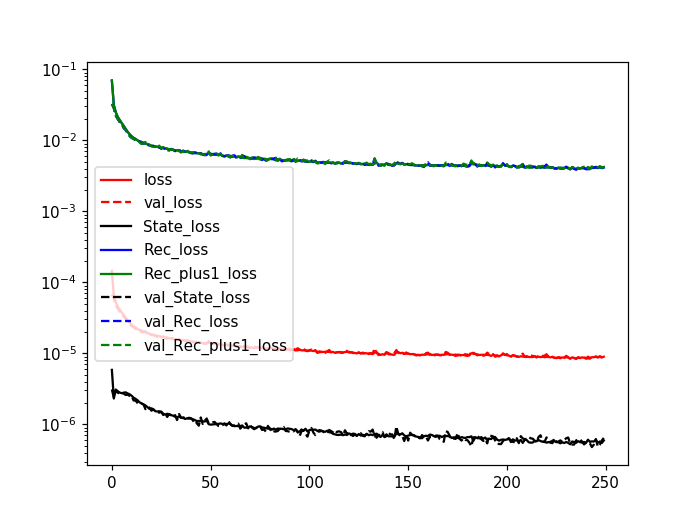

2022-03-31 17:08:18.275964: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-31 17:08:18.276082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 17:08:18.276229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3080 Ti computeCapability: 8.6
coreClock: 1.71GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 849.46GiB/s
2022-03-31 17:08:18.276243: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-31 17:08:18.276262: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-31 17:08:18.276268: I tensorflow/stream_executor/platf

INFO:tensorflow:Assets written to: ./models/DKN/50.timesteps/Soft.control.delay.1c.0r.eigfn/full_model/assets
INFO:tensorflow:Assets written to: ./models/DKN/50.timesteps/Soft.control.delay.1c.0r.eigfn/encoder/assets
INFO:tensorflow:Assets written to: ./models/DKN/50.timesteps/Soft.control.delay.1c.0r.eigfn/decoder/assets
INFO:tensorflow:Assets written to: ./models/DKN/50.timesteps/Soft.control.delay.1c.0r.eigfn/Knet/assets
INFO:tensorflow:Assets written to: ./models/DKN/50.timesteps/Soft.control.delay.1c.0r.eigfn/custom_Knet/assets


In [30]:
if not load_data:
    #%matplotlib inline
    '''
    Check trained models and save
    '''

    # training loss
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    plt.figure()
    plt.plot((history['loss']), 'r')
    plt.plot((history['val_loss']), '--r')
    plt.legend(['loss','val_loss'])
    if model_type == 'DKN':
        plt.plot((history['State_loss']),'k')
        plt.plot((history['Rec_loss']), 'b')
        plt.plot((history['Rec_plus1_loss']), 'g')
        plt.plot((history['val_State_loss']),'--k')
        plt.plot((history['val_Rec_loss']), '--b')
        plt.plot((history['val_Rec_plus1_loss']), '--g')

        plt.legend(['loss','val_loss',
                    'State_loss', 'Rec_loss',
                    'Rec_plus1_loss', 'val_State_loss',
                    'val_Rec_loss','val_Rec_plus1_loss',
                   ])
    plt.yscale('log')
    plt.savefig('{}_Loss_{}c_{}r_eigfn.pdf'.format(system,num_complex_eig_funs,num_real_eig_funs))
    
      
    if model_type == 'FCN':
        full_model.save('./models/{}/{}.timesteps/{}/full_model'.format(model_type,NUM_HISTORICAL_TRAINING_INPUT_STEPS,system))
    elif model_type == 'DKN':
        full_model.save('./models/{}/{}.timesteps/{}.{}c.{}r.eigfn/full_model'.format(model_type,NUM_HISTORICAL_TRAINING_INPUT_STEPS,system,num_complex_eig_funs,num_real_eig_funs))
        encoder.save('./models/{}/{}.timesteps/{}.{}c.{}r.eigfn/encoder'.format(model_type,NUM_HISTORICAL_TRAINING_INPUT_STEPS,system,num_complex_eig_funs,num_real_eig_funs))
        _decoder.save('./models/{}/{}.timesteps/{}.{}c.{}r.eigfn/decoder'.format(model_type,NUM_HISTORICAL_TRAINING_INPUT_STEPS,system,num_complex_eig_funs,num_real_eig_funs))
        Knet.save('./models/{}/{}.timesteps/{}.{}c.{}r.eigfn/Knet'.format(model_type,NUM_HISTORICAL_TRAINING_INPUT_STEPS,system,num_complex_eig_funs,num_real_eig_funs))
        custom_Knet.save('./models/{}/{}.timesteps/{}.{}c.{}r.eigfn/custom_Knet'.format(model_type,NUM_HISTORICAL_TRAINING_INPUT_STEPS,system,num_complex_eig_funs,num_real_eig_funs))

# Plot some visualisation

/home/rl-lab/dkncem_environment/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


<IPython.core.display.Javascript object>


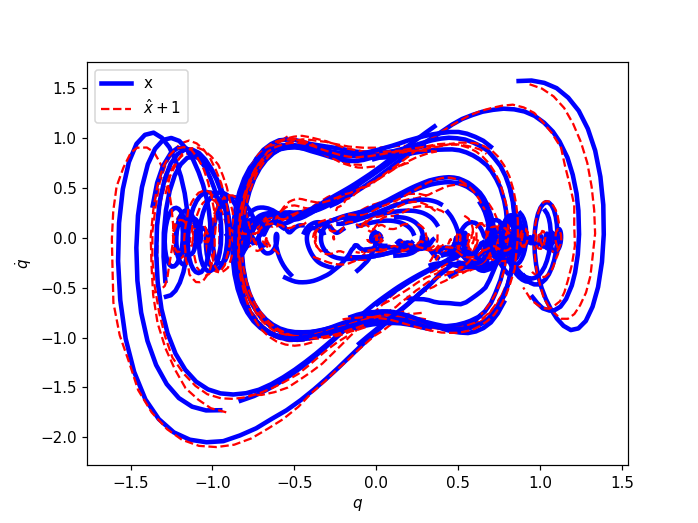

In [31]:
xhat_tp1 = full_model.predict(train_generator[0][0])
fig = plt.figure()
#for i in range(BATCH_SIZE):
#for j,i in enumerate([20,21,23,24,25]):
for j,i in enumerate(range(128)):
    plt.plot(train_generator[0][0][i,:,0],train_generator[0][0][i,:,1],color='b', label = 'x' if j == 0 else "",linewidth=3)
    #plt.scatter(train_generator[0][1][i,:,0],train_generator[0][1][i,:,1],alpha=0.5,marker='+',color='r', label = 'x+1' if j == 0 else "")
    plt.plot(xhat_tp1[i,:,0],xhat_tp1[i,:,1],'--r', label = r'$\hat{x}+1$' if j == 0 else "")
plt.legend()
plt.xlabel(r'$q$')
plt.ylabel(r'$\dot{q}$')
plt.savefig('{}_onestep_prediction_{}c_{}r_eigfn.pdf'.format(system,num_complex_eig_funs,num_real_eig_funs))

In [32]:
# Compute average prediction error
train_error = []
valid_error = []
test_error = []
for batch in range(EVALUATION_INTERVAL):
    train_error.append(((train_generator[0][1] - full_model.predict(train_generator[0][0]))**2))
    valid_error.append(((valid_generator[0][1] - full_model.predict(valid_generator[0][0]))**2))
    test_error.append(((test_generator[0][1] - full_model.predict(test_generator[0][0]))**2))

In [33]:
print('Train Error: Angle = {}, Angular Vel. = {}'.format(
    np.mean(np.array(train_error)[:,:,:,0]),np.mean(np.array(train_error)[:,:,:,1])))
print('Valid Error: Angle = {}, Angular Vel. = {}'.format(
    np.mean(np.array(valid_error)[:,:,:,0]),np.mean(np.array(valid_error)[:,:,:,1])))
print('Test Error: Angle = {}, Angular Vel. = {}'.format(
    np.mean(np.array(test_error)[:,:,:,0]),np.mean(np.array(test_error)[:,:,:,1])))

Train Error: Angle = 0.0014039970956727574, Angular Vel. = 0.004426475654590792
Valid Error: Angle = 0.0024884598224171914, Angular Vel. = 0.009776233500829514
Test Error: Angle = 0.0014189121822968445, Angular Vel. = 0.004691436237569378


# Plots for paper (DKN only)

Here, I want to plot similar to the above but also look at a select few trajectories to show the continuous spectra

In [34]:
# # Load some independent exemplar samples to show evolution
# train_generator_predict = HDF5ImageGenerator(
#         src = data_directory+'/train.hdf5',
#         X_key=X_key,
#         y_key=y_key,
#         classes_key = classes_key,
#         scaler=False, 
#         labels_encoding=False,
#         batch_size=BATCH_SIZE,
#         mode='train',
#         augmenter=augmentor,
#         augmenter_labels = augmenter_labels, 
#         shuffle=False,
# )

if system == 'Rigid.no.control.delay' or system == 'Rigid.control.delay':
    predict_batch_a = 969
    predict_batch_b=predict_batch_c = predict_batch_a

elif system == 'Rigid.PD.control.delay':
    predict_batch_a = 250
    predict_batch_b=predict_batch_c = predict_batch_a
    
elif system == 'Soft.control.delay':

    # Sizes for the exemplar, defined in the hdf5 generator
    # for long trajectory
    predict_batch_a = 2000
    
    # for medium trajectory
    predict_batch_b = 500
    
    # for short trajectory
    predict_batch_c = 5000
    
# For rigid
long_generator_predict = HDF5ImageGenerator(
        src = data_directory+'/long.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, 
        labels_encoding=False, 
        batch_size=predict_batch_a,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels,
        shuffle=True,
)

mid_generator_predict = HDF5ImageGenerator(
        src = data_directory+'/mid.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, 
        labels_encoding=False, 
        batch_size=predict_batch_b,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels, 
        shuffle=True,
)

small_generator_predict = HDF5ImageGenerator(
        src = data_directory+'/small.hdf5',
        X_key=X_key,
        y_key=y_key,
        classes_key = classes_key,
        scaler=False, 
        labels_encoding=False,
        batch_size=predict_batch_c,
        mode='train',
        augmenter=augmentor,
        augmenter_labels = augmenter_labels,
        shuffle=True,
)




# Plot complex eigenfunctions

<IPython.core.display.Javascript object>


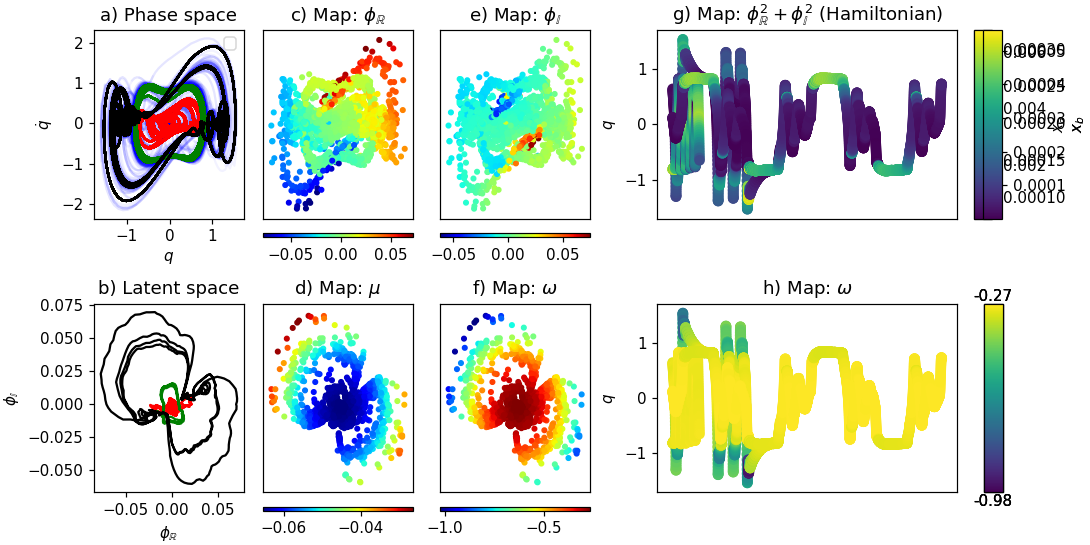

No handles with labels found to put in legend.
/home/rl-lab/dkncem_environment/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/tmp/ipykernel_412947/1009338519.py:100: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax3 = plt.subplot(gs[0,1])
/tmp/ipykernel_412947/1009338519.py:112: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instanc

In [35]:
# This is a really slow and inefficent plot

from matplotlib.gridspec import GridSpec


num_samples = 50 # max 128, but takes ages to plot
num_batches = 1
sample_list = np.random.permutation(range(BATCH_SIZE))[:num_samples]
batch_list = np.random.permutation(range(EVALUATION_INTERVAL))[:num_samples]

EVALUATION_INTERVAL
exemplar_batch = 0


# Iterate over complex eigenfunctions
for eigenfunction_num in range(par['num complex']*2)[::2]:
#for eigenfunction_num in [0]:

    batch = 0

    fig = plt.figure(figsize=(10,5),constrained_layout=True)
    #fig = plt.figure(figsize=(10,5),tight_layout=True)
    gs = GridSpec(2,5,figure=fig)
    #gs = GridSpec(6,5,figure=fig)

    # Plot phase space
    ax1 = plt.subplot(gs[0,0])
    #ax1 = plt.subplot(gs[:3,0])
    # Plot some random samples
    for batch in (batch_list):
        for i in sample_list:
            plt.plot(train_generator[batch][0][i,:,0],train_generator[batch][0][i,:,1],'b',alpha=0.05)
        
    # Plot the exemplars
    #for i in range(predict_batch_c):
    plt.plot(small_generator_predict[exemplar_batch][0][:,:,0],
             small_generator_predict[exemplar_batch][0][:,:,1],'r',label=r'$x_c$' if i ==0 else '')
    #for i in range(predict_batch_b):
    plt.plot(mid_generator_predict[exemplar_batch][0][:,:,0],
             mid_generator_predict[exemplar_batch][0][:,:,1],'g',label=r'$x_b$' if i ==0 else '')
    #for i in range(predict_batch_a):
    plt.plot(long_generator_predict[exemplar_batch][0][:,:,0],
             long_generator_predict[exemplar_batch][0][:,:,1],'k',label=r'$x_a$' if i ==0 else '')
    plt.legend(ncol=1,loc="upper right")
    plt.xlabel(r'$q$')
    plt.ylabel(r'$\dot{q}$')
    plt.title('a) Phase space')

    # Plot latent space 
    ax2 = plt.subplot(gs[1,0])  
    #ax2 = plt.subplot(gs[3:,0]) 
    # Compute the latent mapping over timesteps
    # In this, the batchs are sequential, to show what navigating the latent space looks like step by step
    _, y_ind = Knet.predict(small_generator_predict[exemplar_batch][0])
    plt.plot(y_ind[:,0,eigenfunction_num],  
             y_ind[:,0,eigenfunction_num+1],
            color='r',label = r'$y_c$')
    _, y_ind = Knet.predict(mid_generator_predict[exemplar_batch][0])
    plt.plot(y_ind[:,0,eigenfunction_num],  
             y_ind[:,0,eigenfunction_num+1],
            color='g',label = r'$y_b$')
    _, y_ind = Knet.predict(long_generator_predict[exemplar_batch][0])
    plt.plot(y_ind[:,0,eigenfunction_num],  
             y_ind[:,0,eigenfunction_num+1],
            color='k',label = r'$y_a$')
    
#     # Compute the latent mapping over timesteps (assuming autonomous system defined only by initial state)
#     # This bit of code only makes sense for rigid pendulum without control
#     num_timesteps = 50
#     y_evolve_auto = list()   
#     _, y = Knet.predict((train_generator_predict[batch][0][:,:,:]))
#     for i in range(num_timesteps):
#         Koos, y = custom_Knet.predict(y)
#         y_evolve_auto.append(y)
#     y_evolve_auto = np.concatenate(y_evolve_auto,axis=1) 
#     for i in range(num_timesteps):
#         plt.plot(y_evolve_auto[i,:,eigenfunction_num],
#                  y_evolve_auto[i,:,eigenfunction_num+1],
#                  color='b',alpha=0.5,label = r'$K^{50} y$' if i==0 else '')

    plt.title('b) Latent space')
    plt.xlabel(r'$\phi_\mathbb{R}$')
    plt.ylabel(r'$\phi_\mathbb{I}$')
    
    # Visualise the relationship between latent and state space    
    y_list = list()
    k_list = list()
    # First, get the latent coordinates for each batch
    for batch in  (batch_list):
        # Some redundency here as this is predicted for every eigenfunction, but only needs once
        Koos, y = Knet.predict((train_generator[batch][0][:,:,:]))
        y_list.append(y)
        k_list.append(Koos)
    y_list = np.array(y_list)
    k_list = np.array(k_list)
    
    # Then plot them
    for i,batch in enumerate(batch_list):        
        # Map real part of eigenfunction to phase space
        ax3 = plt.subplot(gs[0,1])
        #ax3 = plt.subplot(gs[:3,1])
        plt.title(r'c) Map: $\phi_\mathbb{R}$')   
        #for i in sample_list:
        plt.scatter(train_generator[batch][0][:,0,0],
                    train_generator[batch][0][:,0,1],
                    c=y_list[i,:,0,eigenfunction_num],
                    cmap='jet',marker='.',
                    vmin=y_list[:,:,:,eigenfunction_num].min(),
                    vmax=y_list[:,:,:,eigenfunction_num].max())      
                
        # Map imag part of eigenfunction to phase space
        ax4 = plt.subplot(gs[0,2])
        #ax4 = plt.subplot(gs[:3,2])
        plt.title(r'e) Map: $\phi_\mathbb{I}$')
        # Just look at the final step (unstable equilibirum) as its more interesting
        plt.scatter(train_generator[batch][0][:,0,0],
                    train_generator[batch][0][:,0,1],
                    c=y_list[i,:,0,eigenfunction_num+1],
                    cmap='jet',marker='.',
                    vmin=y_list[:,:,:,eigenfunction_num+1].min(),
                    vmax=y_list[:,:,:,eigenfunction_num+1].max())
        
        # Map eigenvalue growth/decay to eigenfunction
        ax5 = plt.subplot(gs[1,1])
        #ax5 = plt.subplot(gs[3:,1])
        plt.title(r'd) Map: $\mu$')
        #for i in sample_list:
        plt.scatter(y_list[i,:,:,eigenfunction_num],
                    y_list[i,:,:,eigenfunction_num+1],
                    c=k_list[i,:,:,eigenfunction_num],cmap='jet',marker='.',
                    vmin=k_list[:,:,:,eigenfunction_num].min(),
                    vmax=k_list[:,:,:,eigenfunction_num].max())
        
        # Map eigenvalue freq to eigenfunction
        ax6 = plt.subplot(gs[1,2])
        #ax6 = plt.subplot(gs[3:,2])
        plt.title(r'f) Map: $\omega$')
        plt.scatter(y_list[i,:,:,eigenfunction_num],
                    y_list[i,:,:,eigenfunction_num+1],
                    c=k_list[i,:,:,eigenfunction_num+1],cmap='jet',marker='.',
                   vmin=k_list[:,:,:,eigenfunction_num+1].min(),
                   vmax=k_list[:,:,:,eigenfunction_num+1].max())

    #Plot colourbars
    plt.subplot(gs[0,1])
    #plt.subplot(gs[:3,1])
    plt.colorbar(orientation='horizontal',pad=-0.0)#-0.14
    plt.subplot(gs[1,1])
    #plt.subplot(gs[3:,1])
    plt.colorbar(orientation='horizontal',pad=-0.0)
    plt.subplot(gs[0,2])
    #plt.subplot(gs[:3,2])
    plt.colorbar(orientation='horizontal',pad=-0.0)
    plt.subplot(gs[1,2])
    #plt.subplot(gs[3:,2])
    plt.colorbar(orientation='horizontal',pad=-0.0)

    # Compute latent coordinates and lamdbas for the exemplars
    Koos_small, y_small = Knet.predict((small_generator_predict[0][0][:,:,:]))
    Koos_mid, y_mid = Knet.predict((mid_generator_predict[0][0][:,:,:]))
    Koos_long, y_long = Knet.predict((long_generator_predict[0][0][:,:,:]))

    

    
    # Angle coloured by energy
    # Define some maxes and minimums for the scatter colour
#     vmax = np.max([(y_long[:,:,eigenfunction_num]**2+y_long[:,:,eigenfunction_num+1]**2).max(),
#      (y_mid[:,:,eigenfunction_num]**2+y_mid[:,:,eigenfunction_num+1]**2).max(),
#      (y_small[:,:,eigenfunction_num]**2+y_small[:,:,eigenfunction_num+1]**2).max()])

#     vmin = np.min([(y_long[:,:,eigenfunction_num]**2+y_long[:,:,eigenfunction_num+1]**2).min(),
#      (y_mid[:,:,eigenfunction_num]**2+y_mid[:,:,eigenfunction_num+1]**2).min(),
#      (y_small[:,:,eigenfunction_num]**2+y_small[:,:,eigenfunction_num+1]**2).min()])
    
    ax7 = plt.subplot(gs[0,3:])
    vmin = (y_long[:,:,eigenfunction_num]**2+y_long[:,:,eigenfunction_num+1]**2).min()
    vmax = (y_long[:,:,eigenfunction_num]**2+y_long[:,:,eigenfunction_num+1]**2).max()
    #for i in range(0,predict_batch_a):
    plt.scatter(np.linspace(0,predict_batch_a,predict_batch_a),
                long_generator_predict[0][0][:,-1,0],
                #c=NUM_HISTORICAL_TRAINING_INPUT_STEPS*[
                #    y_long[i,:,eigenfunction_num]**2+y_long[i,:,eigenfunction_num+1]**2
                #],
                #c=y_long[:,:,eigenfunction_num]**2+y_long[:,:,eigenfunction_num+1]**2,
                c=y_long[:,0,eigenfunction_num]**2+y_long[:,0,eigenfunction_num+1]**2,
                #cmap='Greys',
                #vmin = vmin,
                #vmax = vmax,
               )
    cb = plt.colorbar(label=r'$x_a$')
    #cb.ax.text(0.5,-0.01,round(vmin,2), transform=cb.ax.transAxes,va='top',ha='center')
    #cb.ax.text(0.5,1,round(vmax,2), transform=cb.ax.transAxes,va='bottom',ha='center')
    
    #ax8 = plt.subplot(gs[2:4,3:])
    vmin = (y_mid[:,:,eigenfunction_num]**2+y_mid[i,:,eigenfunction_num+1]**2).min()
    vmax = (y_mid[:,:,eigenfunction_num]**2+y_mid[i,:,eigenfunction_num+1]**2).max()
    #for i in range(0,predict_batch_b):
    plt.scatter(np.linspace(0,predict_batch_b,predict_batch_b),
                mid_generator_predict[0][0][:,-1,0],
                c=y_mid[:,0,eigenfunction_num]**2+y_mid[:,0,eigenfunction_num+1]**2,
                #cmap='Greens',
                #vmin = vmin,
                #vmax = vmax,
               )
    cb = plt.colorbar(label=r'$x_b$')
    #cb.ax.text(0.5,-0.01,round(vmin,2), transform=cb.ax.transAxes,va='top',ha='center')
    #cb.ax.text(0.5,1,round(vmax,2), transform=cb.ax.transAxes,va='bottom',ha='center')
    
    #ax9 = plt.subplot(gs[4:,3:])
    vmin = (y_small[:,:,eigenfunction_num]**2+y_small[i,:,eigenfunction_num+1]**2).min()
    vmax = (y_small[:,:,eigenfunction_num]**2+y_small[i,:,eigenfunction_num+1]**2).max()
    #for i in range(0,predict_batch_c):
    plt.scatter(np.linspace(0,predict_batch_c,predict_batch_c),
                small_generator_predict[0][0][:,-1,0],
                c=y_small[:,0,eigenfunction_num]**2+y_small[:,0,eigenfunction_num+1]**2,
                #cmap='Reds',
                #vmin = vmin,
                #vmax = vmax,
               )
    #cb = plt.colorbar(ticks=[],label=r'$x_c$')
    cb = plt.colorbar(label=r'$x_c$')
    #cb.ax.text(0.5,-0.01,round(vmin,2), transform=cb.ax.transAxes,va='top',ha='center')
    #cb.ax.text(0.5,1,round(vmax,2), transform=cb.ax.transAxes,va='bottom',ha='center')
    plt.ylabel(r'$q$')
    plt.xlabel(r'Timesteps')
    
    #plt.subplot(gs[:2,3:])
    plt.title('g) Map: $\phi_\mathbb{R}^2+\phi_\mathbb{I}^2$ (Hamiltonian)')
#     plt.text(0,3,r'$x_a$')#,bbox=dict(facecolor='white',edgecolor='red'))
#     plt.text(0,1.2,r'$x_b$')#,bbox=dict(facecolor='white',edgecolor='green'))
#     plt.text(0,-2,r'$x_c$')#,bbox=dict(facecolor='white',edgecolor='black'))


    # Angle coloured by frequency
    vmax = np.max([Koos_long[:,:,eigenfunction_num+1].max(),
                   Koos_mid[:,:,eigenfunction_num+1].max(),
                   Koos_small[:,:,eigenfunction_num+1].max()])
    vmin = np.min([Koos_long[:,:,eigenfunction_num+1].min(),
                   Koos_mid[:,:,eigenfunction_num+1].min(),
                   Koos_small[:,:,eigenfunction_num+1].min()])
    
    ax8 = plt.subplot(gs[1,3:])
    #ax8 = plt.subplot(gs[3,3:])
    #for i in range(0,predict_batch_a):
    plt.scatter(range(predict_batch_a),
                long_generator_predict[0][0][:,-1,0],
                c=Koos_long[:,0,eigenfunction_num+1],
                vmin=vmin,
                vmax=vmax,
               )
    cb = plt.colorbar(ticks=[])
    cb.ax.text(0.5,-0.01,round(vmin,2), transform=cb.ax.transAxes,va='top',ha='center')
    cb.ax.text(0.5,1,round(vmax,2), transform=cb.ax.transAxes,va='bottom',ha='center') 
    #ax8 = plt.subplot(gs[4,3:])
    #for i in range(0,predict_batch_b):
    plt.scatter(range(predict_batch_b),
                mid_generator_predict[0][0][:,-1,0],
                c=Koos_mid[:,0,eigenfunction_num+1],
                vmin=vmin,
                vmax=vmax,
                )
    cb = plt.colorbar(ticks=[])
    cb.ax.text(0.5,-0.01,round(vmin,2), transform=cb.ax.transAxes,va='top',ha='center')
    cb.ax.text(0.5,1,round(vmax,2), transform=cb.ax.transAxes,va='bottom',ha='center') 
    #ax8 = plt.subplot(gs[5,3:])
    #for i in range(0,predict_batch_c):
    plt.scatter(range(predict_batch_c),
                small_generator_predict[0][0][:,-1,0],
                c=Koos_small[:,0,eigenfunction_num+1],
                vmin=vmin,
                vmax=vmax,
               )
    cb = plt.colorbar(ticks=[])
    cb.ax.text(0.5,-0.01,round(vmin,2), transform=cb.ax.transAxes,va='top',ha='center')
    cb.ax.text(0.5,1,round(vmax,2), transform=cb.ax.transAxes,va='bottom',ha='center') 

    plt.title(r'h) Map: $\omega$')
#     plt.text(0,3,r'$x_a$')#,bbox=dict(facecolor='white',edgecolor='red'))
#     plt.text(0,1.2,r'$x_b$')#,bbox=dict(facecolor='white',edgecolor='green'))
#     plt.text(0,-2,r'$x_c$')#,bbox=dict(facecolor='white',edgecolor='black'))
    plt.ylabel(r'$q$')
    plt.xlabel(r'Timesteps')

    for ax in [ax3,ax4,ax5,ax6,ax7,ax8]:
        ax.get_xaxis().set_visible(False)
    for ax in [ax3,ax4,ax5,ax6]:        
        ax.get_yaxis().set_visible(False)

    
    plt.savefig('{}_DKN_analysis_complex_eigfn_{}_and_{}_outof_{}.pdf'.format(system,eigenfunction_num+1,eigenfunction_num+2,2*par['num complex']))


<IPython.core.display.Javascript object>


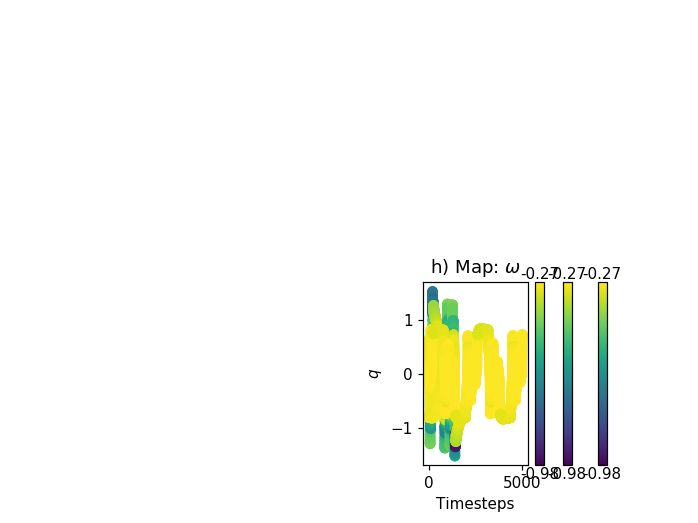

Text(0.5, 0, 'Timesteps')

In [42]:
fig = plt.figure()
ax8 = plt.subplot(gs[1,3:])
#ax8 = plt.subplot(gs[3,3:])
#for i in range(0,predict_batch_a):
plt.scatter(range(predict_batch_a),
            long_generator_predict[0][0][:,-1,0],
            c=Koos_long[:,0,eigenfunction_num+1],
            vmin=vmin,
            vmax=vmax,
           )
cb = plt.colorbar(ticks=[])
cb.ax.text(0.5,-0.01,round(vmin,2), transform=cb.ax.transAxes,va='top',ha='center')
cb.ax.text(0.5,1,round(vmax,2), transform=cb.ax.transAxes,va='bottom',ha='center') 
#ax8 = plt.subplot(gs[4,3:])
#for i in range(0,predict_batch_b):
plt.scatter(range(predict_batch_b),
            mid_generator_predict[0][0][:,-1,0],
            c=Koos_mid[:,0,eigenfunction_num+1],
            vmin=vmin,
            vmax=vmax,
            )
cb = plt.colorbar(ticks=[])
cb.ax.text(0.5,-0.01,round(vmin,2), transform=cb.ax.transAxes,va='top',ha='center')
cb.ax.text(0.5,1,round(vmax,2), transform=cb.ax.transAxes,va='bottom',ha='center') 
#ax8 = plt.subplot(gs[5,3:])
#for i in range(0,predict_batch_c):
plt.scatter(range(predict_batch_c),
            small_generator_predict[0][0][:,-1,0],
            c=Koos_small[:,0,eigenfunction_num+1],
            vmin=vmin,
            vmax=vmax,
           )
cb = plt.colorbar(ticks=[])
cb.ax.text(0.5,-0.01,round(vmin,2), transform=cb.ax.transAxes,va='top',ha='center')
cb.ax.text(0.5,1,round(vmax,2), transform=cb.ax.transAxes,va='bottom',ha='center') 

plt.title(r'h) Map: $\omega$')
#     plt.text(0,3,r'$x_a$')#,bbox=dict(facecolor='white',edgecolor='red'))
#     plt.text(0,1.2,r'$x_b$')#,bbox=dict(facecolor='white',edgecolor='green'))
#     plt.text(0,-2,r'$x_c$')#,bbox=dict(facecolor='white',edgecolor='black'))
plt.ylabel(r'$q$')
plt.xlabel(r'Timesteps')

<IPython.core.display.Javascript object>


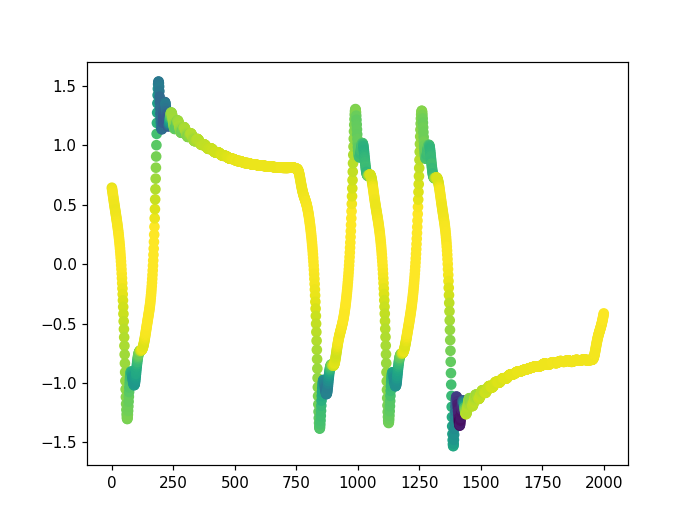

In [37]:
fig = plt.figure()
plt.scatter(range(predict_batch_a),
            long_generator_predict[0][0][:,-1,0],
            c=Koos_long[:,0,eigenfunction_num+1],
            vmin=vmin,
           )

In [38]:
predict_batch_c

5000

<IPython.core.display.Javascript object>


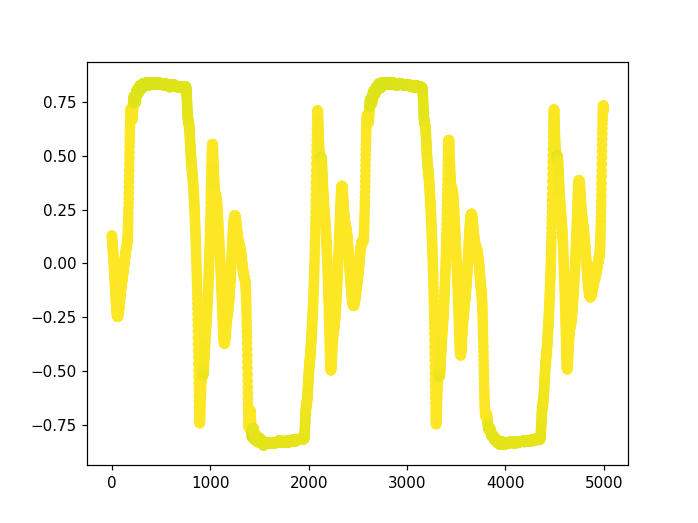

In [39]:
fig =plt.figure()
plt.scatter(range(predict_batch_c),
            small_generator_predict[0][0][:,-1,0],
            c=Koos_small[:,0,eigenfunction_num+1],
            vmin=vmin,
            vmax=vmax,
           )

In [40]:
y_long.shape

(2000, 1, 2)

In [ ]:
print(np.squeeze(y_list[batch][:,:,eigenfunction_num]).shape)
print(train_generator[batch][0][:,-1,0].shape)
print((y_mid[:,:,eigenfunction_num]**2+y_mid[:,:,eigenfunction_num+1]**2).shape)
print(long_generator_predict[0][0][:,-1,0].shape)

# Plot real eigenfunctions

#not sure best way to do this yet

In [41]:

for real_eig in range(2*num_complex_eig_funs,2*num_complex_eig_funs+num_real_eig_funs):

    y_max = y_list[:,:,:,real_eig].max()
    y_min = y_list[:,:,:,real_eig].min()

    k_max = k_list[:,:,:,real_eig].max()
    k_min = k_list[:,:,:,real_eig].min()

    fig = plt.figure()
    for batch in range (EVALUATION_INTERVAL): 
        plt.subplot(121)
        plt.scatter(train_generator[batch][0][:,0,0],train_generator[batch][0][:,0,1],c=y_list[batch][:,0,real_eig],
                   vmin=y_min,vmax=y_max,cmap='jet')
        plt.title(r'Map: $\phi$')

        plt.subplot(122)
        plt.scatter(train_generator[batch][0][:,0,0],train_generator[batch][0][:,0,1],c=k_list[batch][:,0,real_eig],
                    vmin=k_min,vmax=k_max,cmap='jet')
        plt.title(r'Map: $\lambda$')

        

    plt.subplot(121)
    plt.colorbar()  
    plt.subplot(122)
    plt.colorbar()        

ERROR! Session/line number was not unique in database. History logging moved to new session 806
